# Domain Generation Algorithms (DGA) 

MITRE ATT&CK: https://attack.mitre.org/techniques/T1323/

## Preamble
In order to facilitate command and control (C2), Malware will require a rendevous point with an internet based server.  Historically, this connection was facilitated with a hardcoded domain name within the Malware.  This domain name would then be reached out periodically.

In order to gain a persistance and foothold, Malware will often rendevous with internet servers to establish command and control behaviours.  Historically, this was done with a single domain name that was registered by an adversary, however, this technique was countered by reverse engineering Malware samples and blocking the domain.

Adversaries countered this tactic by the implementation og Domain Generation Algorithms - an algorithm that will generate a number of domain names and effectively killing the ability to 

To combat the use of blacklists on hard-coded domain-names, a domain generation algorithm is often coded into Malware samples.  This technique allows adversaries generate domain names and effectively bypass any blocking behaviours.

Traditional approaches are reactive - it involves reverse engineering the Malware binaries.  This is naturally time consuming.

## Detection Approach(s)

* NXDomains
If a single host is making a large number of NXDomain (non-existant) - this could indicate Malware usage.  This is still a reactive approach, it requires the sum of NX domains to be met before approach could be made.

* Feature Engineering
Look at intrinsic features

* RNN
Scalable and easy to use technique for detection

## Datasets
* Cisco's Umbrella Popularity
 The popularity list contains our most queried domains based on passive DNS usage across our Umbrella global network of more than 100 Billion requests per day with 65 million unique active users, in more than 165 countries. Unlike Alexa, the metric is not based on only browser based 'http' requests from users but rather takes in to account the number of unique client IPs invoking this domain relative to the sum of all requests to all domains. In other words, our popularity ranking reflects the domain’s relative internet activity agnostic to the invocation protocols and applications where as ’site ranking’ models (such as Alexa) focus on the web activity over port 80 mainly from browsers. 
https://s3-us-west-1.amazonaws.com/umbrella-static/index.html


* DGA Sets from NetLab


## References
[1] - https://blog.malwarebytes.com/security-world/2016/12/explained-domain-generating-algorithm/

[2] - https://www.youtube.com/watch?v=jm7wH2G0h6c

<hr>

## NX Domain Detection


<hr>

## Recurrent Neural Networks (RNN)

In [55]:
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
import sklearn
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split

## Data Ingestion & Preprocessing

In [12]:
# Ingesting Benign Domains
benignDomains_df = pd.read_csv('dataset/CISCO-top-1m.csv', names=['domain'])
benignDomains_df['class'] = 'benign'
benignDomains_df['src'] = 'cisco'

# Ingesting Malicious Domains
maliciousDomains_df = pd.read_csv('dataset/dga-domains.txt', sep='\t', usecols=[0,1], names=['src', 'domain'])
maliciousDomains_df['class'] = 'malicious'

# Merging Datasets
dataset_df = pd.concat([maliciousDomains_df[0:500], benignDomains_df[0:500]], sort=False)
dataset_df = dataset_df.sample(frac=1)
dataset_df.head()

,src,domain,class
136,cisco,a.akamaiedge.net,benign
141,gameover,15f3re43sl45w1mm4f65zhbsm6.com,malicious
435,gameover,yoct3xowrw3i8s0fep1dy93pk.com,malicious
325,cisco,s.yimg.com,benign
229,gameover,1wzsta1714mnfnm9jlr1xsepvv.net,malicious


## NN Preprocessing

In [38]:
benign_domains = benignDomains_df['domain'][0:500].tolist()
dga_domains = maliciousDomains_df['domain'][0:500].tolist()

X = benign_domains + dga_domains

unique_chars = enumerate(set(''.join(X))) 
chars_dict = dict()
for i, x in unique_chars: #index of enum starts with 0
    print('i: ' + str(i) + '  x: ' + x)
    chars_dict[x] = i + 1 #leave 0 for padding

    

#index 0 is also going to be a feature(padding/unknown).
max_features_num = len(chars_dict) + 1
max_features_num




i: 0  x: 9
i: 1  x: m
i: 2  x: 6
i: 3  x: b
i: 4  x: l
i: 5  x: .
i: 6  x: v
i: 7  x: z
i: 8  x: n
i: 9  x: 4
i: 10  x: r
i: 11  x: e
i: 12  x: a
i: 13  x: u
i: 14  x: 5
i: 15  x: 3
i: 16  x: 8
i: 17  x: p
i: 18  x: w
i: 19  x: y
i: 20  x: s
i: 21  x: c
i: 22  x: 0
i: 23  x: 2
i: 24  x: -
i: 25  x: f
i: 26  x: i
i: 27  x: j
i: 28  x: h
i: 29  x: t
i: 30  x: x
i: 31  x: o
i: 32  x: 7
i: 33  x: d
i: 34  x: k
i: 35  x: 1
i: 36  x: q
i: 37  x: g


39

In [39]:


# Convert characters to int
X_in_int = []
for domain in X:
    domain_in_int = []
    for c in domain:
        domain_in_int.append(chars_dict[c])
    X_in_int.append(domain_in_int)

X = X_in_int

maxlen = np.max([len(x) for x in X])
maxlen

40

In [40]:
X = sequence.pad_sequences(X, maxlen=maxlen)
X

array([[ 0,  0,  0, ..., 22, 32,  2],
       [ 0,  0,  0, ..., 22, 32,  2],
       [ 0,  0,  0, ..., 22, 32,  2],
       ...,
       [ 0,  0,  0, ..., 32, 11, 38],
       [ 0,  0,  0, ...,  9, 12, 30],
       [ 0,  0,  0, ...,  4, 27,  8]], dtype=int32)

In [41]:
X.shape

(1000, 40)

In [42]:
Y = np.hstack([np.zeros(len(benign_domains)),np.ones(len(dga_domains))])

In [43]:
def build_model(max_features_num, maxlen):
    """Build LSTM model"""
    model = Sequential()
    model.add(Embedding(max_features_num, 64, input_length=maxlen))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['binary_crossentropy','acc'])

    return model

In [44]:
pos_neg_cutpoint = len(benign_domains)
print("The cut point will be "+ str(pos_neg_cutpoint))

The cut point will be 500


In [47]:
sampling_size = 250

pos_indices = random.sample(range(pos_neg_cutpoint),sampling_size)
neg_indices = random.sample(range(pos_neg_cutpoint, len(X)),sampling_size)

In [48]:


new_X = X[pos_indices + neg_indices]
new_Y = Y[pos_indices + neg_indices]



In [49]:
max_epoch=25
nfolds=10
batch_size=128

In [50]:
#call backs
from keras.callbacks import EarlyStopping
cb = []

cb.append(EarlyStopping(monitor='val_loss', 
                        min_delta=0, #an absolute change of less than min_delta, will count as no improvement
                        patience=5, #number of epochs with no improvement after which training will be stopped
                        verbose=0, 
                        mode='auto', 
                        baseline=None, 
                        restore_best_weights=False))

In [51]:
model = build_model(max_features_num, maxlen)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 64)            2496      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 35,585
Trainable params: 35,585
Non-trainable params: 0
_________________

In [52]:
history = model.fit(x=new_X, y=new_Y, 
                    batch_size=batch_size, 
                    epochs=max_epoch, 
                    verbose=1, 
                    callbacks=cb, 
                    validation_split=0.2, #
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0,
                    steps_per_epoch=None, 
                    validation_steps=None)

Instructions for updating:
Use tf.cast instead.
Train on 400 samples, validate on 100 samples
Epoch 1/25
400/400 [==============================] - 1s 3ms/step - loss: 0.6754 - binary_crossentropy: 0.6754 - acc: 0.6075 - val_loss: 0.7791 - val_binary_crossentropy: 0.7791 - val_acc: 0.0000e+00
Epoch 2/25
400/400 [==============================] - 0s 472us/step - loss: 0.5895 - binary_crossentropy: 0.5895 - acc: 0.6250 - val_loss: 1.2195 - val_binary_crossentropy: 1.2195 - val_acc: 0.0700
Epoch 3/25
400/400 [==============================] - 0s 409us/step - loss: 0.5394 - binary_crossentropy: 0.5394 - acc: 0.7525 - val_loss: 1.2274 - val_binary_crossentropy: 1.2274 - val_acc: 0.2300
Epoch 4/25
400/400 [==============================] - 0s 474us/step - loss: 0.4354 - binary_crossentropy: 0.4354 - acc: 0.8075 - val_loss: 1.5663 - val_binary_crossentropy: 1.5663 - val_acc: 0.3800
Epoch 5/25
400/400 [==============================] - 0s 491us/step - loss: 0.4464 - binary_crossentropy: 0.4464

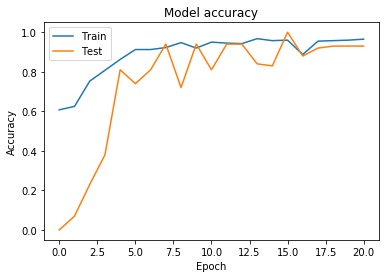

In [56]:
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [66]:


# # Convert characters to int
# X_in_int = []
# for domain in X:
#     domain_in_int = []
#     for c in domain:
#         domain_in_int.append(chars_dict[c])
#     X_in_int.append(domain_in_int)

# X = X_in_int

# maxlen = np.max([len(x) for x in X])
# maxlen



tstString = 'qwe.com'
testList = []
for char in tstString:
    testList.append(chars_dict[char])
output = sequence.pad_sequences([testList], maxlen=maxlen)

print(testList)
print(output)
print(model.predict_classes(output))

[37, 19, 12, 6, 22, 32, 2]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 37 19 12  6 22 32  2]]
[[0]]
